In [1]:
import os
import datetime
import numpy as np
#import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import uproot
import math
from glob import glob
import awkward as ak
%matplotlib inline

%load_ext autoreload
%autoreload 2

prop_cycle = plt.rcParams['axes.prop_cycle']
_colors = prop_cycle.by_key()['color']

_save_dir = 'plots/'

# colors = {
#     211: 'lightgreen',
#     2122: 'lightblue',
#     13: 'blue',
#     11: 'navy',
#     111: 'black'
# }

colors = ['black', 'navy', 'blue', 'lightblue', 'lightgreen',]

# lariat colors
colors = [
    # 'gray', 
    (24/ 255, 33/ 255, 92/ 255),
    'gray',
    (109/ 255, 102/ 255, 146/ 255),
    (88/ 255, 130/ 255, 175/ 255),
    (129/ 255, 181/ 255, 203/ 255),
    (197/ 255, 221/ 255, 205/ 255),
]

In [2]:
# config05_2, better JGG with field
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config05_2/merged_sim_arcs_beamline_simple_9858of30k.root'
# n_pions = 9858 * 30000
# config = 'config05_2'

# config07_1, BFIELD=0
f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config07_1/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
n_pions = 9511 * 30000
config = 'config07_1'

# config08_1, BFIELD=0, cryo and LAr
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config08_1/merged_sim_arcs_beamline_simple_9881of30k_config08_1.root'
# f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_9881of30k_config08_1.root'
# n_pions = 9881 * 30000
# config = 'config08_1'

In [3]:
file = uproot.open(f)
print(file.keys())

n_spills = n_pions / 2.5e5
n_hours = n_spills / 60
n_months = n_spills / 60 / 24 / 30

print('Number of pions:', n_pions)
print('Number of spills:', n_spills)
print('Number of hours:', n_hours)
print('Number of months:', n_months)


['VirtualDetector;1', 'VirtualDetector/Det4;1', 'VirtualDetector/Det7;1', 'VirtualDetector/JGGDet1;1', 'VirtualDetector/JGGDet2;1', 'VirtualDetector/JGGDet3;1']
Number of pions: 285330000
Number of spills: 1141.32
Number of hours: 19.022
Number of months: 0.026419444444444443


In [4]:
file[f'VirtualDetector/JGGDet1'].keys()

['x',
 'y',
 'z',
 'Px',
 'Py',
 'Pz',
 't',
 'PDGid',
 'EventID',
 'TrackID',
 'ParentID',
 'Weight']

In [5]:
f'Particles / {n_pions:.1e}' + r'$\pi$' + 'on target ({n_hours} hours of data)' 

'Particles / 2.9e+08$\\pi$on target ({n_hours} hours of data)'

In [6]:
# det = 8
# branches = [f'PxDet{det}', f'PyDet{det}', f'PzDet{det}', f'PDGidDet{det}', f'TrackPresentDet{det}']
# arrays = file[f'EventsDet{det}'].arrays(branches, entry_start=0, entry_stop=1)

In [7]:
file[f'VirtualDetector/JGGDet2'].num_entries
# file.keys()

33816545

In [175]:
branches = ['x', 'y', 'z', 'Px', 'Py', 'Pz', 'PDGid', 'EventID', 'TrackID']

df1 = file[f'VirtualDetector/Det7'].arrays(branches, library='pd')
print(len(df1))
df1 = df1.drop_duplicates(['EventID', 'TrackID'])
print(len(df1))
print(df1)

df2 = file[f'VirtualDetector/JGGDet1'].arrays(branches, library='pd')
print(len(df2))
df2 = df2.drop_duplicates(['EventID', 'TrackID'])
print(len(df2))
print(df2)

# df2.loc[(df2['EventID'] == 29970112.0) & (df2['TrackID'] == 121664.0)]

24372801
23851007
                   x           y        z          Px          Py  \
0         -12.295263   23.291000  37987.5  -26.720316   39.191833   
1         -24.075411  141.114014  38012.5   -0.075467   -0.061722   
2         169.331497 -138.029633  37987.5    0.004642   -0.003912   
3        -228.884979  165.766754  37987.5   -0.082162    0.058753   
4         121.023071 -124.313683  37987.5    0.062218   -0.068078   
...              ...         ...      ...         ...         ...   
24372796 -196.912109  -23.919720  37987.5   -6.628531    4.959712   
24372797  110.489632   27.482815  38012.5    0.065752    0.042584   
24372798 -165.567886    3.503659  37987.5 -628.954895  242.481125   
24372799 -113.803490  -31.265154  37987.5   -0.017784   -0.005497   
24372800 -159.259094 -177.090988  38012.5    0.182700   -0.033680   

                    Pz  PDGid     EventID   TrackID  
0         62712.902344  211.0  29970012.0       1.0  
1            -0.146260   22.0  29970056.0   2

KeyboardInterrupt: 

In [ ]:
df_all = df1.merge(df2, on=['EventID', 'TrackID'], 
                   how='left', indicator=True,
                   suffixes=('_Det7', '_JGGDet1'))

# Drop particles that are not in both detectors
df_all = df_all[df_all['_merge'] == 'both']

# Drop PDGid_Det7, as it's the same as PDGid_JGGDet1
df_all = df_all.drop(['PDGid_Det7'], axis=1)

# Rename PDGid_JGGDet1 to PDGid
df_all = df_all.rename(columns={"PDGid_JGGDet1": "PDGid", })

df_all.query('PDGid==11')

In [8]:
class Particle:
    x = None
    y = None
    z = None
    px = None
    py = None
    pz = None
    pdg = None
    p = None
    theta = None
    phi = None

    def __init__(self):
        pass

def get_particle(mask=None):
    '''
    Returns all the needed varibles in a Particle class
    '''

    if mask is None:
        mask = [True] * len(arrays['x'])

    x = arrays['x'][mask]
    y = arrays['y'][mask]
    z = arrays['z'][mask]
    px = arrays['Px'][mask]
    py = arrays['Py'][mask]
    pz = arrays['Pz'][mask]
    pdg = arrays['PDGid'][mask]

    p = np.sqrt(px**2 + py**2 + pz**2)
    theta = np.arccos(pz / p) / np.pi * 180
    phi = np.arctan2(py, px) / np.pi * 180

    particle = Particle()
    particle.x = np.array(x)
    particle.y = np.array(y)
    particle.z = np.array(z)
    particle.px = np.array(px)
    particle.py = np.array(py)
    particle.pz = np.array(pz)
    particle.pdg = np.array(pdg)
    particle.p = np.array(p)
    particle.theta = np.array(theta)
    particle.phi = np.array(phi)

    return particle

def apply_mask(particle, mask):
    
    particle.x = particle.x[mask]
    particle.y = particle.y[mask]
    particle.z = particle.z[mask]
    particle.px = particle.px[mask]
    particle.py = particle.py[mask]
    particle.pz = particle.pz[mask]
    particle.pdg = particle.pdg[mask]
    particle.p = particle.p[mask]
    particle.theta = particle.theta[mask]
    particle.phi = particle.phi[mask]
    
    return particle

def get_values_labels(particle, variable='p'):

    pdg = particle.pdg

    if variable == 'p':
        var = particle.p
    elif variable == 'theta':
        var = particle.theta
    elif variable == 'phi':
        var = particle.phi
        
    kaons = var[np.abs(pdg)==321]
    positrons = var[pdg==-11]
    electrons = var[pdg==+11]
    muons = var[np.abs(pdg)==13]
    protons = var[np.abs(pdg)==2212]
    pions = var[np.abs(pdg)==211]
    others = var[ (np.abs(pdg)!=321) & (np.abs(pdg)!=11) & (np.abs(pdg)!=13) & (np.abs(pdg)!=2212) & (np.abs(pdg)!=211)]
    gamma = var[np.abs(pdg)==22]
    
    values = [
        # others,
        # gamma,
        kaons,
        positrons,
        electrons,
        muons,
        protons,
        pions,
    ]

    tot = len(kaons) + len(electrons) + len(positrons) + len(muons) + len(protons) + len(pions)
    # tot += len(others)
    # tot += len(gamma)
    
    labels = [
        # 'others' + f', ({len(others) / tot * 100:.1f}%)',
        # 'gamma' + f', ({len(gamma) / tot * 100:.1f}%)',
        r'$K^\pm$' + f', ({len(kaons):.2e}, {len(kaons) / tot * 100:.1f}%)',
        r'$e^+$' + f', ({len(positrons):.2e}, {len(positrons) / tot * 100:.1f}%)',
        r'$e^-$' + f', ({len(electrons):.2e}, {len(electrons) / tot * 100:.1f}%)',
        r'$\mu^\pm$' + f', ({len(muons):.2e}, {len(muons) / tot * 100:.1f}%)',
        r'$p^\pm$' + f', ({len(protons):.2e}, {len(protons) / tot * 100:.1f}%)',
        r'$\pi^\pm$' + f', ({len(pions):.2e}, {len(pions) / tot * 100:.1f}%)'
    ]

    return values, labels

In [9]:
for det in ['Det4', 'Det7', 'JGGDet1', 'JGGDet2', 'JGGDet3']:

    if file[f'VirtualDetector/{det}'].num_entries == 0:
        print(f'No events for {det}')
        continue

    branches = ['x', 'y', 'z', 'Px', 'Py', 'Pz', 'PDGid']
    arrays = file[f'VirtualDetector/{det}'].arrays(branches)
    mask = arrays[f'PDGid'] != 0

    particle = get_vars(mask)
    particle = apply_mask(particle, mask=(particle.p>81))

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [GeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    pdg = particle.pdg

    for i, variable in enumerate(['p', 'theta', 'phi']):

        values, labels = get_values_labels(particle, variable)
    
        bins = x_bins[variable]
        if det == 'Det4' and i == 0:
            bins = np.linspace(200, 1600, 30)
        if det == 'Det5' and i == 0:
            bins = np.linspace(150, 2500, 50)
        
        ax[i].hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
        ax[i].legend()
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)
    
        ax[i].set_xlabel(x_axis[variable])
        ax[i].set_ylabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)' )
        ax[i].set_title(f'Detector: {det}', loc='right', fontsize=8)
        ax[i].set_title(r'$p>80$ MeV', loc='left', fontsize=8)
        
        # if det == 'Det7' or det == 'Det8' or 'JGG' in det:
        #     ax[0][i].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'spectra_g4blsimple_{config}_det{det}.pdf')
    plt.show()


NameError: name 'get_vars' is not defined

In [ ]:
for det in ['Det4', 'Det7', 'JGGDet1', 'JGGDet2', 'JGGDet3']:

    if file[f'VirtualDetector/{det}'].num_entries == 0:
        print(f'No events for {det}')
        continue

    branches = ['x', 'y', 'z', 'Px', 'Py', 'Pz', 'PDGid']
    arrays = file[f'VirtualDetector/{det}'].arrays(branches)
    mask = arrays[f'PDGid'] != 0

    particle = get_vars(mask)
    particle = apply_mask(particle, mask=(particle.p>81))

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [GeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    pdg = particle.pdg


    # bins = x_bins['p']
    # values, labels = get_values_labels(particle, 'p')
    # ax[1][0].hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
    # ax[1][0].legend()
    # handles, labels = ax[1][0].get_legend_handles_labels()
    # ax[1][0].legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)

    # ax[1][0].set_xlabel(x_axis['p'])
    # ax[1][0].set_ylabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)' )
    # ax[1][0].set_title(f'Det{det}', loc='right', fontsize=8)
    

    xbins = np.linspace(-235-60, 235+60, 50)
    ybins = np.linspace(-200-60, 200+60, 50)
    if det == 'Det4':
        xbins = np.linspace(-64-1195.0827-10, 64-1195.0827+10, 50)
        ybins = np.linspace(-62.5-20.4724-10, 62.5-20.4724+10, 50)
    ax[0].hist2d(np.array(particle.x), np.array(particle.y), bins=[xbins, ybins])
    ax[0].set_xlabel('X [mm]')
    ax[0].set_ylabel('Y [mm]')
    ax[0].set_title(f'Detector: {det}', loc='right', fontsize=8)

    mask_e = np.abs(pdg) == 11
    ax[1].hist2d(np.array(particle.x[mask_e]), np.array(particle.y[mask_e]), bins=[xbins, ybins])
    ax[1].set_xlabel('X [mm]')
    ax[1].set_ylabel('Y [mm]')
    ax[1].set_title(f'Detector: {det} - Electrons Only', loc='right', fontsize=8)

    mask_p = particle.p > 200
    ax[2].hist2d(np.array(particle.x[mask_e&mask_p]), np.array(particle.y[mask_e&mask_p]), bins=[xbins, ybins])
    ax[2].set_xlabel('X [mm]')
    ax[2].set_ylabel('Y [mm]')
    ax[2].set_title(f'Detector: {det} - Electrons Only, p > 200 MeV', loc='right', fontsize=8)
    
    plt.tight_layout()
    # plt.savefig(_save_dir + f'spectra_g4blsimple_{config}_det{det}.pdf')
    plt.show()


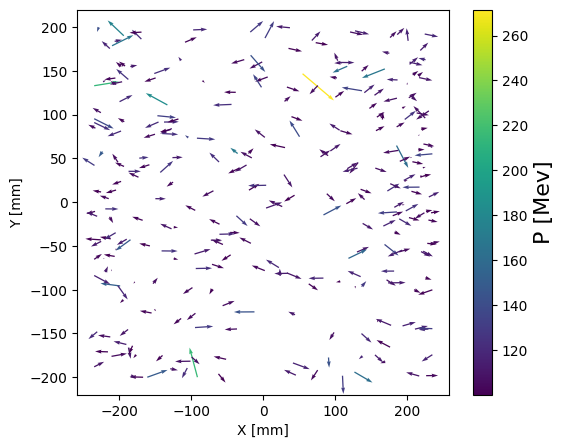

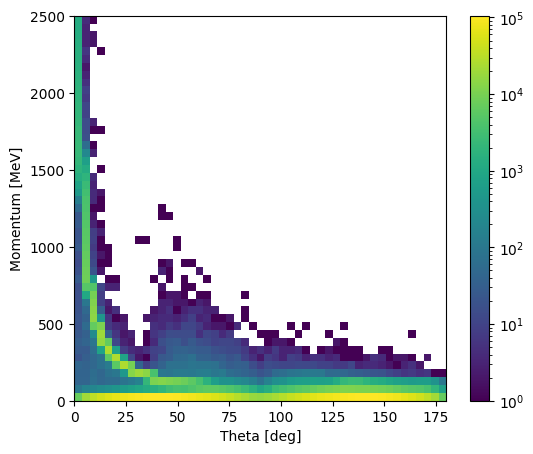

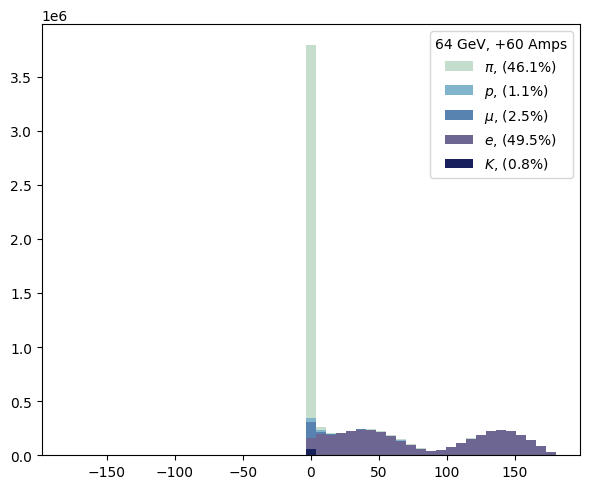

In [63]:
# for det in ['Det4', 'Det7', 'JGGDet1', 'JGGDet2', 'JGGDet3']:
for det in ['JGGDet1']:

    if file[f'VirtualDetector/{det}'].num_entries == 0:
        print(f'No events for {det}')
        continue

    branches = ['x', 'y', 'z', 'Px', 'Py', 'Pz', 'PDGid']
    arrays = file[f'VirtualDetector/{det}'].arrays(branches)
    mask = arrays[f'PDGid'] != 0

    x = arrays['x'][mask]
    y = arrays['y'][mask]
    z = arrays['z'][mask]
    px = arrays['Px'][mask]
    py = arrays['Py'][mask]
    pz = arrays['Pz'][mask]
    p = np.sqrt(px**2 + py**2 + pz**2)
    pdg = arrays[f'PDGid'][mask]

    theta = np.arccos(pz / p) / np.pi * 180
    phi = np.arctan2(py, px) / np.pi * 180

    x_axis = ['Theta [deg]']
    x_bins = [np.linspace(-180, 180, 50)]

    mask_e = np.abs(pdg) == 11
    mask_theta = theta > 100
    mask_p = (p > 100) & (p < 500)
    tot_mask = mask_e & mask_theta & mask_p
    n_entries = 300
    X = np.array(x[tot_mask])[:n_entries]
    Y = np.array(y[tot_mask])[:n_entries]
    U = np.array(px[tot_mask])[:n_entries]
    V = np.array(py[tot_mask])[:n_entries]
    M = np.array(p[tot_mask])[:n_entries]

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

    q = ax.quiver(X, Y, U, V, M) #, alpha=0.1)
    cbar = fig.colorbar(q)
    cbar.ax.set_ylabel('P [Mev]', fontsize=16)

    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')

    plt.show()


    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

    mask_p = (p > 100)
    tot_mask = mask_e # & mask_p
    
    h = ax.hist2d(np.array(theta[tot_mask]), np.array(p[tot_mask]),
                  bins=[np.linspace(0, 180, 50), np.linspace(0, 2500, 50)],
                  norm=mpl.colors.LogNorm())

    fig.colorbar(h[3], ax=ax)

    ax.set_xlabel('Theta [deg]')
    ax.set_ylabel('Momentum [MeV]')

    plt.show()


    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

    for i, var in enumerate([theta]):
        
        kaons = var[np.abs(pdg)==321]
        electrons = var[np.abs(pdg)==11]
        muons = var[np.abs(pdg)==13]
        protons = var[np.abs(pdg)==2212]
        pions = var[np.abs(pdg)==211]
        others = var[ (np.abs(pdg)!=321) & (np.abs(pdg)!=11) & (np.abs(pdg)!=13) & (np.abs(pdg)!=2212) & (np.abs(pdg)!=211)]
        gamma = var[np.abs(pdg)==22]
        
        values = [
            # p_others,
            # p_gamma,
            var[np.abs(pdg)==321],
            var[np.abs(pdg)==11],
            var[np.abs(pdg)==13],
            var[np.abs(pdg)==2212],
            var[np.abs(pdg)==211],
        ]
    
        tot = len(kaons) + len(electrons) + len(muons) + len(protons) + len(pions)
        # tot += len(others)
        # tot += len(gamma)
        
        labels = [
            # 'others' + f', ({len(others) / tot * 100:.1f}%)',
            # 'gamma' + f', ({len(gamma) / tot * 100:.1f}%)',
            r'$K$' + f', ({len(kaons) / tot * 100:.1f}%)',
            r'$e$' + f', ({len(electrons) / tot * 100:.1f}%)',
            r'$\mu$' + f', ({len(muons) / tot * 100:.1f}%)',
            r'$p$' + f', ({len(protons) / tot * 100:.1f}%)',
            r'$\pi$' + f', ({len(pions) / tot * 100:.1f}%)'
        ]
    
        bins = x_bins[i]
        if det == 'Det4' and i == 0:
            bins = np.linspace(200, 1600, 30)
        if det == 'Det5' and i == 0:
            bins = np.linspace(150, 2500, 50)
        
        ax.hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
        ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)
    
        # ax.set_xlabel(x_axis[i])
        # ax.set_ylabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)' )
        # ax.set_title(f'Det{det}', loc='right', fontsize=8)
        

    xbins = np.linspace(-235-60, 235+60, 50)
    ybins = np.linspace(-200-60, 200+60, 50)
    # if det == 'Det4':
    #     xbins = np.linspace(-64-1195.0827-200, 64-1195.0827+200, 50)
    #     ybins = np.linspace(-62.5-20.4724-200, 62.5-20.4724+200, 50)
    # ax[1][0].hist2d(np.array(x), np.array(y), bins=[xbins, ybins])
    # ax[1][0].set_xlabel('X [mm]')
    # ax[1][0].set_ylabel('Y [mm]')
    # ax[1][0].set_title(f'Det{det}', loc='right', fontsize=8)

    # mask_e = np.abs(pdg) == 11
    # ax[1][1].hist2d(np.array(x[mask_e]), np.array(y[mask_e]), bins=[xbins, ybins])
    # ax[1][1].set_xlabel('X [mm]')
    # ax[1][1].set_ylabel('Y [mm]')
    # ax[1][1].set_title(f'Det{det} - Electrons Only', loc='right', fontsize=8)

    # mask_p100 = p > 100
    # ax[1][1].hist2d(np.array(x[mask_e & mask_p100]), np.array(y[mask_e & mask_p100]), bins=[xbins, ybins])
    # ax[1][1].set_xlabel('X [mm]')
    # ax[1][1].set_ylabel('Y [mm]')
    # ax[1][1].set_title(f'Det{det} - Electrons Only, p > 100 MeV', loc='right', fontsize=8)
    
    plt.tight_layout()
    # plt.savefig(_save_dir + f'spectra_g4blsimple_{config}_det{det}.pdf')
    plt.show()
